In [6]:
import pandas as pd
import numpy as np
from matplotlib import pyplot
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
from numpy import log
from statsmodels.tsa.stattools import adfuller
from pandas.plotting import autocorrelation_plot
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.arima_model import ARIMA
from sklearn import datasets
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.arima_model import ARIMA
from datetime import datetime
%matplotlib inline
sns.set()

from statsmodels.tsa.stattools import acf, pacf
#import statsmodels.tsa.statespace.sarimax as SARIMAX

## 1_ Data Collection

### Transactions' DB

In [7]:
trans_df = pd.read_csv('/Users/mehrnazakbari/Google Drive/BLUEROCK LOGISTICS/Data/Trans_BLR.csv', usecols = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15], sep =';', encoding = 'utf-8')
#trans_df.head()

### Masters' DB

In [8]:
depot_add = pd.read_excel('/Users/mehrnazakbari/Google Drive/BLUEROCK LOGISTICS/Data/masterdata20190918.xlsx', sheet_name = 'Depot Account_Addreses')
#depot_add.head()

## 2_ Data Cleansing

In [9]:
#Type_List = ['COL', 'RET']
#trans_df = trans_df.loc[trans_df['T_DOC_TYPE'].isin(Type_List)]
trans_df = trans_df.loc[trans_df['T_DOC_TYPE'] == 'COL']

trans_df['T_EFFECTIVE_DATE'] = pd.to_datetime(trans_df['T_EFFECTIVE_DATE'])
trans_df['Date'] = trans_df.apply(lambda r:r['T_EFFECTIVE_DATE'].date(), axis = 1)
trans_df = trans_df.dropna(subset = ['Date'])

trans_df = trans_df[['Date', 'T_DOC_TYPE', 'T_SENDING_ID', 'T_RTI_NAME', 'T_ACT_HAND_OUT_QTY']]
trans_df = trans_df.reset_index()
trans_df = trans_df.drop('index', axis = 1)
trans_df.head()

,Date,T_DOC_TYPE,T_SENDING_ID,T_RTI_NAME,T_ACT_HAND_OUT_QTY
0,2014-12-22,COL,8716532103527,CC Euro Container Base,60
1,2014-12-22,COL,8716532103527,CC Euro Container Post 170,240
2,2014-07-09,COL,8716532100492,CC Container Base,4
3,2014-07-09,COL,8716532100492,CC Container Shelf,30
4,2014-07-04,COL,8716532100492,CC Container Base,4


In [10]:
depot_add = depot_add[['name', 'code', 'country']]
#depot_add.head()

## 3_ Data Integration

In [11]:
trans_full = trans_df.join(depot_add.set_index('code'), on = 'T_SENDING_ID')
trans_full = trans_full.drop(['T_SENDING_ID', 'T_DOC_TYPE'], axis =1)
trans_full.head()

,Date,T_RTI_NAME,T_ACT_HAND_OUT_QTY,name,country
0,2014-12-22,CC Euro Container Base,60,NL-Bleiswijk-CCNL,NL
1,2014-12-22,CC Euro Container Post 170,240,NL-Bleiswijk-CCNL,NL
2,2014-07-09,CC Container Base,4,NL-Bleiswijk Bloemenveiling Holland,NL
3,2014-07-09,CC Container Shelf,30,NL-Bleiswijk Bloemenveiling Holland,NL
4,2014-07-04,CC Container Base,4,NL-Bleiswijk Bloemenveiling Holland,NL


## 4_ Filter (Country = Italy)

In [12]:
trans_full = trans_full.loc[trans_full['country'] == 'IT']
trans_full = trans_full.sort_values('Date', ascending = True)
#trans_full['name'].unique()

## 5_ Functions

In [13]:
def RTI(df):
    rti = df['T_RTI_NAME'].unique()
    n = 0
    for x in range(len(rti)):
        n += 1
        print('\n' + str(n) + '_ ' + rti[x])
    if len(rti) > 1:
        n += 1
        print('\n' + str(n) + '_ ' + 'All Containers')
    
    #return df

In [14]:
def RTI_choice(df):
    rt = df['T_RTI_NAME'].unique()
    rti_list = []
    q = raw_input('\n Do you want to choose all RTIs? (Yes/No) : ')
    if q == 'Yes':
        df1 = df
    elif q == 'No':
        n = int(raw_input('\n How many RTI(s) you want to choose: '))
        if n >= 1:
            for x in range (1, n):
                rti = int(raw_input('\n Enter your choice '+ str(x) + ': '))
                rti_list.append(rt[rti])
                x += 1

        else:
            rti = raw_input('\n Enter the number of your choice: ')
            rti_list = rt[rti]

                
    else:
        print('\n Invalid input.')

    return rti_list
    

In [15]:
def RTI_choice1(df):
    rtt = df['T_RTI_NAME'].unique()
    rti = (int(input('\n Choose a container number from the list above: '))) - 1
    if rti< len(rtt):
        print('\n Your choice is: ' + rtt[rti])
        df = df.loc[df['T_RTI_NAME'] == rtt[rti]]
    elif rti == len(rtt):
        print('\n You chose All RTIs in Germany.')

    return df

In [16]:
def periodic_plot(df, p):
    
    depots = df['name'].unique()   
    if (p == 'Weekly') :
        #df = df.resample('1W').sum()
        for x in range(len(depots)):
            b = df.groupby(['Date', 'name']).sum().unstack('name', fill_value=0)
            b.resample('1W').plot(figsize=(20,10), linewidth=5, fontsize=20)
            plt.title('RTI Weekly Growth in Diverse Depots', fontsize=20)
            plt.xlabel('Weekly', fontsize=20)
            plt.show()
            return b
            
            
            
            #df_depot = df.loc[df['name'] == depots[x].encode('utf-8')]
            #df_depot = df_depot.resample('1W').sum()
            #df_depot.plot(figsize=(20,10), linewidth=5, fontsize=20)
            #plt.title(str(x+1) + '_ ' + depots[x], fontsize=20)
            #plt.xlabel(p , fontsize=20);
            #x += 1
            #return df            
        
        
        
    elif (p == 'Monthly'):
        for x in range(len(depots)):
            df_depot = df[df['name'] == depots[x]]
            df_depot = df_depot.resample('1M').sum()
            x += 1
    elif (p == 'Quarterly'):
        for x in range(len(depots)):
            df_depot = df[df['name'] == depots[x]]
            df_depot = df_depot.resample('1Q').sum()
            x += 1
    else:
        print('\n Invalid input.')
    
    return df

In [17]:
def plot_prova(c):
    b = c.groupby(['Date', 'name']).resample('1M').sum().unstack('name', fill_value=0)
    b.plot(figsize=(20,10), linewidth=5, fontsize=20)
    plt.title('RTI Monthly Growth in Diverse Depots', fontsize=20)
    plt.xlabel('Monthly', fontsize=20)
    plt.show()
    return b

## 6_ State of the Art

In [18]:
print('\n List of Containers in Italy: ')
RTI(trans_full)


 List of Containers in Italy: 

1_ CC Container Extensions 66

2_ CC Container Shelf

3_ CC Container Base

4_ CC Container Post 180

5_ CC Container Extensions 33

6_ CC Euro Container Post 110

7_ CC Euro Container Base

8_ CC Euro Container Shelf

9_ CC ½ Container Base

10_ CC ½ Container Shelf

11_ CC Euro Container Post 170

12_ CC Container Base NON Tagged

13_ CC Euro Rolly

14_ CC Adapter Tray Euro Rolly

15_ CC Euro Dolly

16_ CC Adapter Tray Euro Dolly

17_ CC ½ Container Base NON Tagged

18_ All Containers


In [19]:
c = RTI_choice1(trans_full)
c = c.dropna()
depots = c['name'].unique()

c.Date = pd.to_datetime(c.Date)
c = c.sort_values('Date', ascending = True)
tutto = c
c = c.groupby(['Date', 'name'], as_index = False).sum()
c = c.set_index('Date')
#c.head()


 Choose a container number from the list above: 3

 Your choice is: CC Container Base


In [20]:
depo = c['name'].unique()
print('\n The list of depo(s) the chosen RTI is collected from is as follows:')
#b = bytes(depo)
#str(b, encoding = 'utf-8')
for x in range(len(depo)):
    print('\n' + str(x+1) + '_ ' + depo[x])
    c.loc[c['name'] == depo[x]]



 The list of depo(s) the chosen RTI is collected from is as follows:

1_ I 48 Latina Floratoscana

2_ I 35 Bari Capitanio

3_ I 02 Albenga Ciesse

4_ I 03 Giarre Weistra HUB

5_ I 11 S.Benedetto Ciarrocchi

6_ I 43 Milano Alpetrans

7_ I 47 Pescia Floratoscana

8_ I 50 Padova Torello

9_ I 51 Marostica Alpetrans

10_ I 52 Terme Consorzio

11_ I Castor Italy srl Albenga Repair

12_ I Sector Agri Repair Albenga

13_ I 71 Albenga HUB


## 7_ History of Transactions in every Italian Inventory

### 7.1_ Daily basis

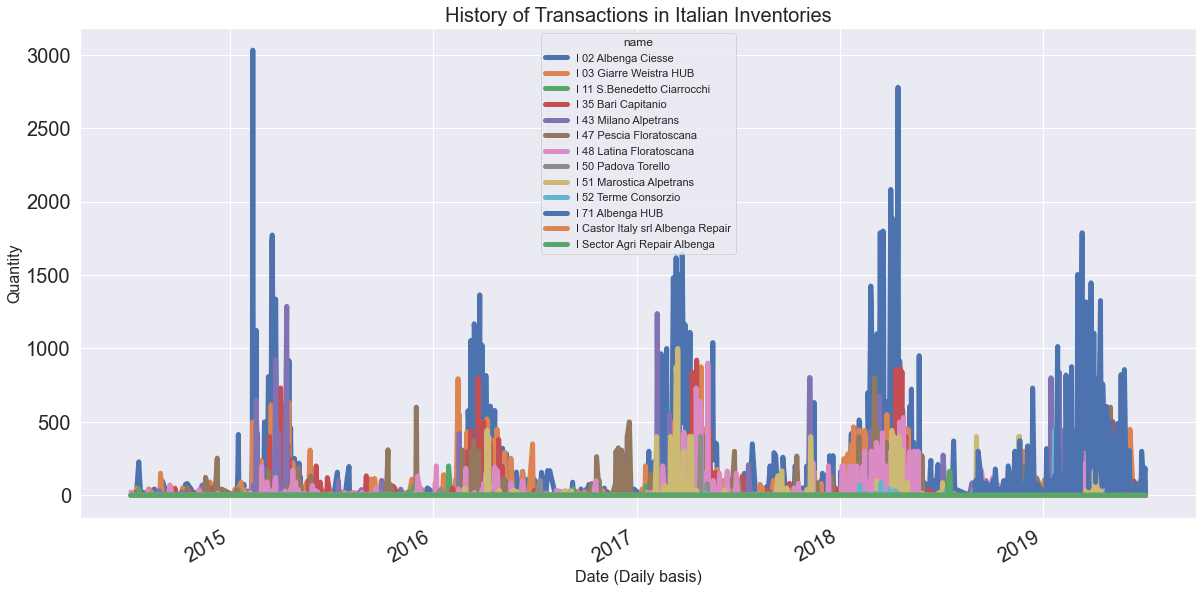

In [21]:
deps_q = c.groupby(['Date', 'name'])['T_ACT_HAND_OUT_QTY'].sum()
deps_q.unstack('name', fill_value=0).plot(figsize=(20,10), linewidth=5, fontsize=20)
plt.title('History of Transactions in Italian Inventories', fontsize=20)
plt.xlabel('Date (Daily basis)', fontsize=16)
plt.ylabel('Quantity', fontsize=16)
plt.show()

### 7.2_ Weekly basis

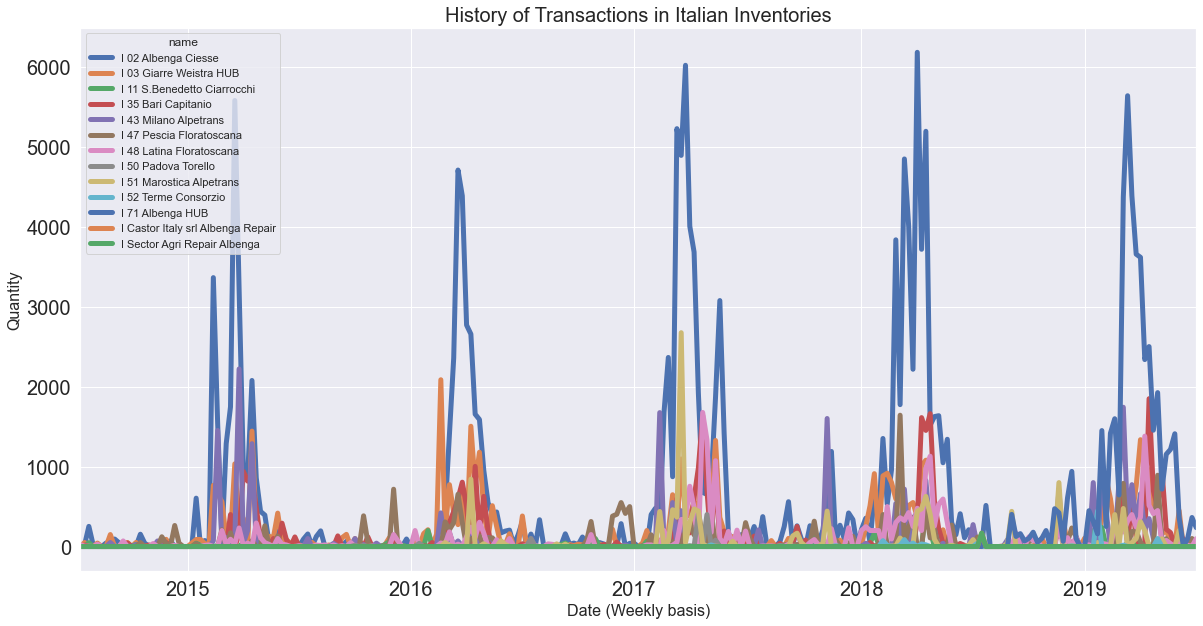

In [22]:
c1 = c.groupby(['Date', 'name'])['T_ACT_HAND_OUT_QTY'].sum().unstack('name', fill_value=0)
c_week = c1.resample('1W').sum()
c_week.plot(figsize=(20,10), linewidth=5, fontsize=20)
plt.title('History of Transactions in Italian Inventories', fontsize=20)
plt.xlabel('Date (Weekly basis)', fontsize=16)
plt.ylabel('Quantity', fontsize=16)
plt.show()
#c_week

### 7.3_ Seasonal basis

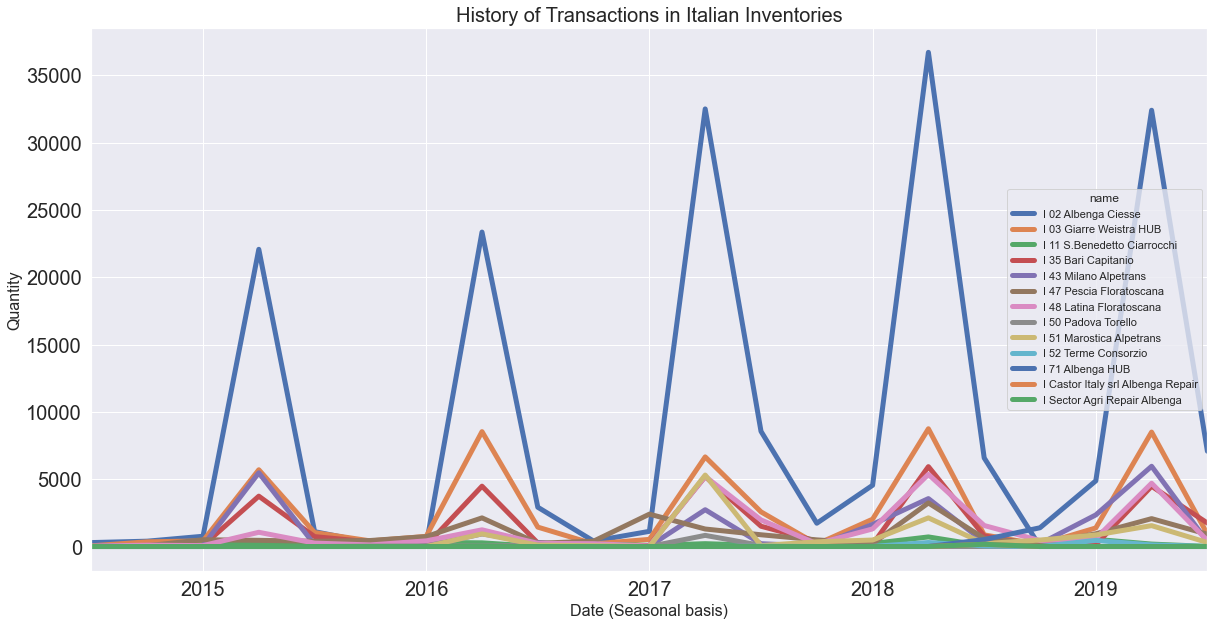

In [23]:
# c1 = c.groupby(['Date', 'name'])['T_ACT_HAND_OUT_QTY'].sum().unstack('name', fill_value=0)
deps_q_3m = c1.resample('3M').sum()
deps_q_3m.plot(figsize=(20,10), linewidth=5, fontsize=20)
plt.title('History of Transactions in Italian Inventories', fontsize=20)
plt.xlabel('Date (Seasonal basis)', fontsize=16)
plt.ylabel('Quantity', fontsize=16)
plt.show()

## 8_ All Transactions in Italy

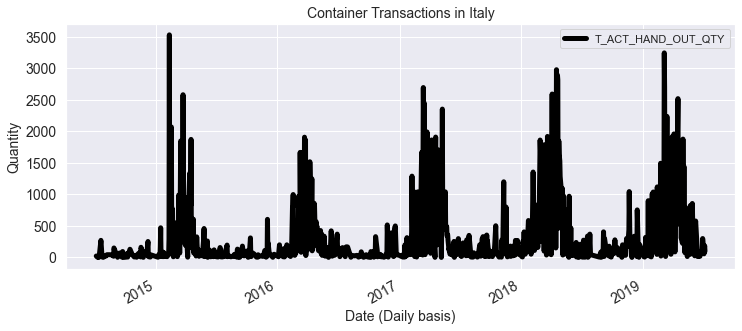

In [24]:
tutto = tutto.groupby('Date').sum()
tutto.plot(figsize=(12, 5), linewidth=5, fontsize=14, color = 'black')
plt.title('Container Transactions in Italy', fontsize = 14)
plt.xlabel('Date (Daily basis)', fontsize = 14)
plt.ylabel('Quantity', fontsize = 14)
plt.show()

### 8.1_ Seasonal Aggregation

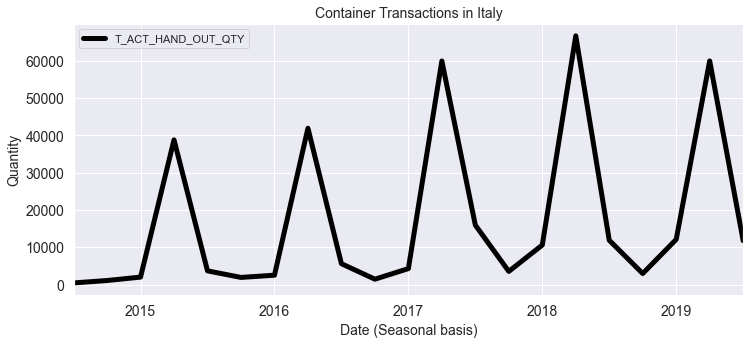

In [25]:
ita_3m = tutto.resample('3M').sum()
ita_3m.plot(figsize=(12, 5), linewidth=5, fontsize = 14, color = 'black')
plt.title('Container Transactions in Italy', fontsize = 14)
plt.xlabel('Date (Seasonal basis)', fontsize = 14)
plt.ylabel('Quantity', fontsize = 14)
plt.show()

#### 8.1.1_ AutoCorrelation Function

/Users/mehrnazakbari/.pyenv/versions/3.7.3/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:572: FutureWarning: fft=True will become the default in a future version of statsmodels. To suppress this warning, explicitly set fft=False.
  FutureWarning


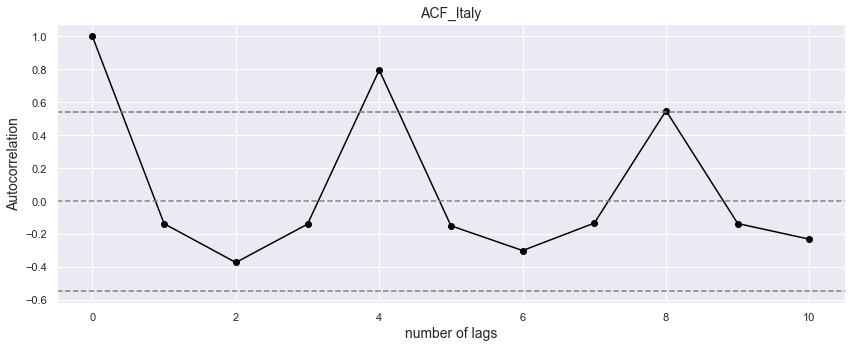

In [26]:
#depot = c['name'].nunique()
ita_3m_q = ita_3m[['T_ACT_HAND_OUT_QTY']].dropna()
#tutti = tutto_week[['T_ACT_HAND_OUT_QTY']].dropna()
ita_3m_acf = acf(ita_3m_q, nlags=10)
plt.figure(figsize=(12, 5))
plt.plot(ita_3m_acf, marker="o", color = 'black')
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(depo)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(depo)),linestyle='--',color='gray')
plt.title('ACF_Italy', fontsize = 14)
plt.xlabel('number of lags', fontsize = 14)
plt.ylabel('Autocorrelation', fontsize = 14)
plt.tight_layout()

#### 8.1.2_ Partial AutoCorrelation Function

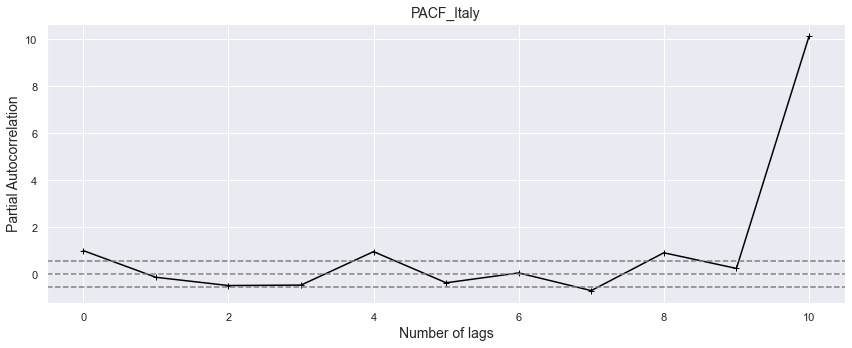

In [27]:
ita_3m_pacf = pacf(ita_3m_q, nlags = 10 , method='ols')
#Plot PACF:
plt.figure(figsize=(12, 5))
plt.plot(ita_3m_pacf, marker='+', color = 'black')
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(depo)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(depo)),linestyle='--',color='gray')
plt.title('PACF_Italy', fontsize=14)    
plt.xlabel('Number of lags', fontsize = 14)
plt.ylabel('Partial Autocorrelation', fontsize = 14)
plt.tight_layout()

#### 8.1.3_ Prediction

In [28]:
X = ita_3m.values
size = int(len(X) * 0.8)
train_3m, test_3m = X[0:size], X[size:len(X)]
history = [x for x in train_3m]

In [29]:
import statsmodels.api as sm

my_order = (1,0,1)
my_seasonal_order = (3,0,1,3)
model = sm.tsa.statespace.SARIMAX(train_3m, order=my_order, seasonal_order=my_seasonal_order)
model_fit = model.fit(disp = False)

/Users/mehrnazakbari/.pyenv/versions/3.7.3/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:1006: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
/Users/mehrnazakbari/.pyenv/versions/3.7.3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


In [30]:
yhat = model_fit.forecast(steps = 5)
yhat

array([28904.73715226,  9243.82502104,  2653.08253234, 27071.89539872,
       15437.91007181])

In [31]:
test_3m

array([[11881],
       [ 2967],
       [12116],
       [59959],
       [11761]])

Text(0, 0.5, 'Quantity')

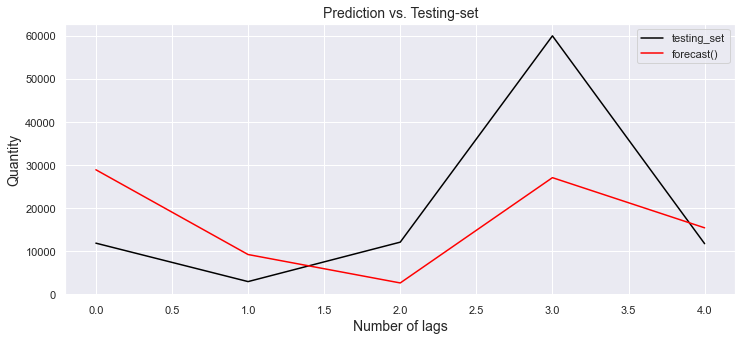

In [32]:
plt.figure(figsize=(12, 5))
pyplot.plot(test_3m, color = 'black', label = 'testing_set')
pyplot.plot(yhat, color = 'red', label = 'forecast()')
plt.legend()
plt.title('Prediction vs. Testing-set', fontsize=14)    
plt.xlabel('Number of lags', fontsize = 14)
plt.ylabel('Quantity', fontsize = 14)

#### 8.1.4_ Accuracy

In [33]:
mse_Italy_3m = mean_squared_error(test_3m, yhat)
print('MSE: ' + str(mse_Italy_3m))

MSE: 302766856.5411216


### 8.2_ Differencing the Time-Series (Seasonal Aggregation)

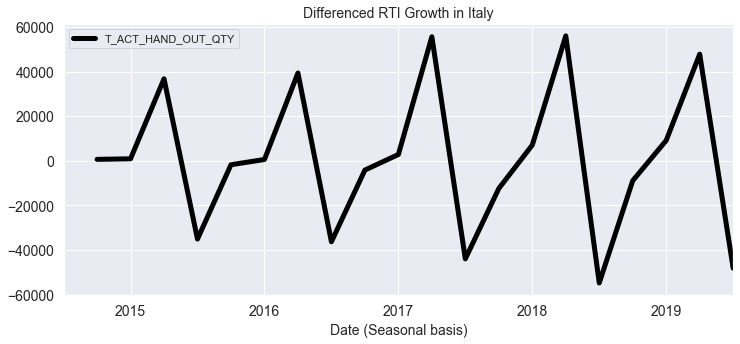

In [34]:
ita_3m_diff = ita_3m.diff()
ita_3m_diff.plot(figsize=(12,5), linewidth=5, fontsize=14, color = 'black')
plt.title('Differenced RTI Growth in Italy', fontsize=14)
plt.xlabel('Date (Seasonal basis)', fontsize=14)
plt.show()

#### 8.2.1_ ACF

/Users/mehrnazakbari/.pyenv/versions/3.7.3/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:572: FutureWarning: fft=True will become the default in a future version of statsmodels. To suppress this warning, explicitly set fft=False.
  FutureWarning


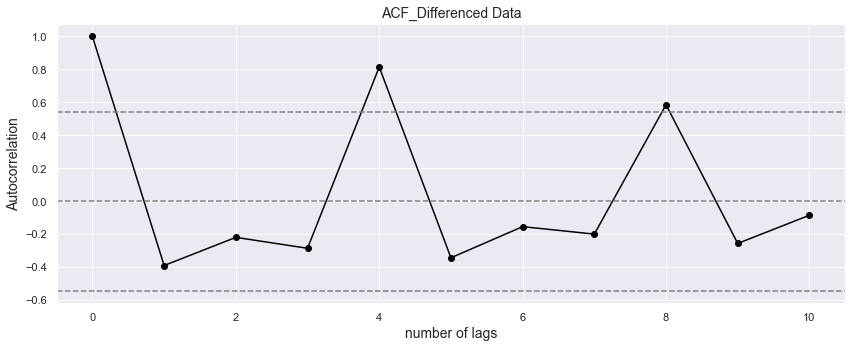

In [35]:
ita_3m_diff_q = ita_3m_diff[['T_ACT_HAND_OUT_QTY']].dropna()
#tutti = tutto_week[['T_ACT_HAND_OUT_QTY']].dropna()
ita_3m_diff_acf = acf(ita_3m_diff_q, nlags=10)
plt.figure(figsize=(12, 5))
plt.plot(ita_3m_diff_acf, marker="o", color = 'black')
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(depo)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(depo)),linestyle='--',color='gray')
plt.title('ACF_Differenced Data', fontsize = 14)
plt.xlabel('number of lags', fontsize = 14)
plt.ylabel('Autocorrelation', fontsize = 14)
plt.tight_layout()

#### 8.2.2_ PACF

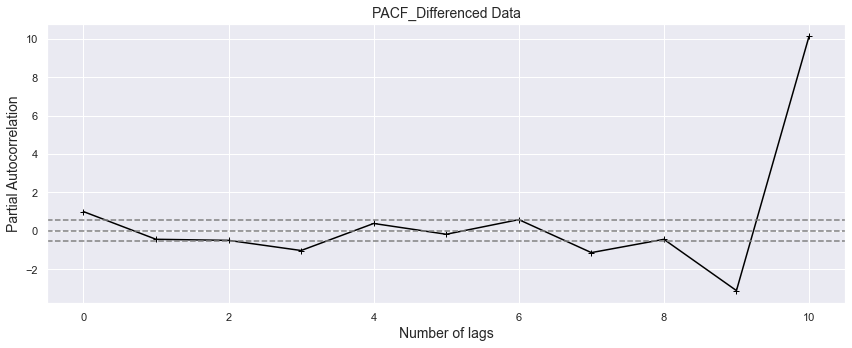

In [36]:
ita_3m_diff_pacf = pacf(ita_3m_diff_q, nlags = 10 , method='ols')
#Plot PACF:
plt.figure(figsize=(12, 5))
plt.plot(ita_3m_diff_pacf, marker='+', color = 'black')
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(depo)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(depo)),linestyle='--',color='gray')
plt.title('PACF_Differenced Data', fontsize=14)    
plt.xlabel('Number of lags', fontsize = 14)
plt.ylabel('Partial Autocorrelation', fontsize = 14)
plt.tight_layout()

#### 8.2.3_ Prediction

In [37]:
import statsmodels.api as sm

my_order = (1,1,1)
my_seasonal_order = (3,1,1,3)
model_diff = sm.tsa.statespace.SARIMAX(train_3m, order=my_order, seasonal_order=my_seasonal_order)
model_diff_fit = model_diff.fit(disp = False)

/Users/mehrnazakbari/.pyenv/versions/3.7.3/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:975: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/mehrnazakbari/.pyenv/versions/3.7.3/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:994: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'


In [38]:
yhat_diff = model_diff_fit.forecast(steps = 5, typ = 'levels')
yhat_diff

array([ 4890.13474712, 19990.28402178, 37828.94964351, 21311.29458964,
       48317.83746063])

Text(0, 0.5, 'Quantity')

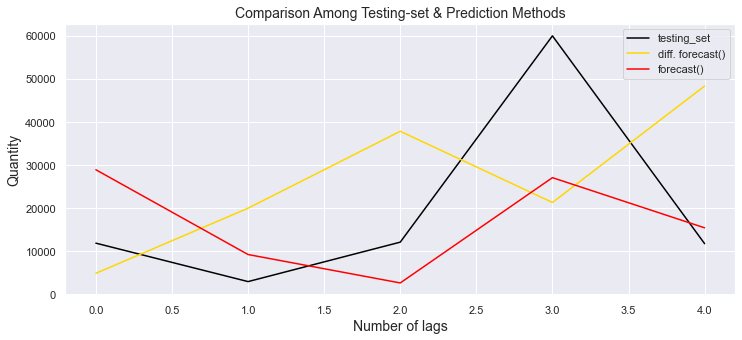

In [39]:
plt.figure(figsize=(12, 5))
pyplot.plot(test_3m, color = 'black', label = 'testing_set')
pyplot.plot(yhat_diff, color = 'gold', label = 'diff. forecast()')
pyplot.plot(yhat, color = 'red', label = 'forecast()')
plt.legend()
plt.title('Comparison Among Testing-set & Prediction Methods', fontsize=14)    
plt.xlabel('Number of lags', fontsize = 14)
plt.ylabel('Quantity', fontsize = 14)

#### 8.2.4_ Accuracy

In [40]:
mse_Italy_diff_3m = mean_squared_error(test_3m, yhat_diff)

if(mse_Italy_diff_3m < mse_Italy_3m):
    print("The YELLOW line is more accurate")
    print("\nDifferencing makes the prediction more Accurate.")
elif(mse_Italy_diff_3m > mse_Italy_3m):
    print("The RED line is more accurate")
    print("\nThus, differencing does NOT make the prediction more Accurate.")

The RED line is more accurate

Thus, differencing does NOT make the prediction more Accurate.


### 8.3_ Aggregation on 6 months' basis

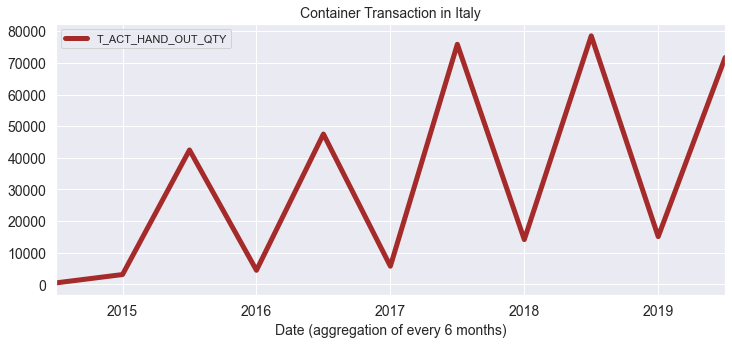

In [41]:
ita_6m = tutto.resample('6M').sum()
ita_6m.plot(figsize=(12, 5), linewidth=5, fontsize = 14, color = 'brown')
plt.title('Container Transaction in Italy', fontsize = 14)
plt.xlabel('Date (aggregation of every 6 months)', fontsize = 14)
plt.show()

#### 8.3.1_ ACF

/Users/mehrnazakbari/.pyenv/versions/3.7.3/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:572: FutureWarning: fft=True will become the default in a future version of statsmodels. To suppress this warning, explicitly set fft=False.
  FutureWarning


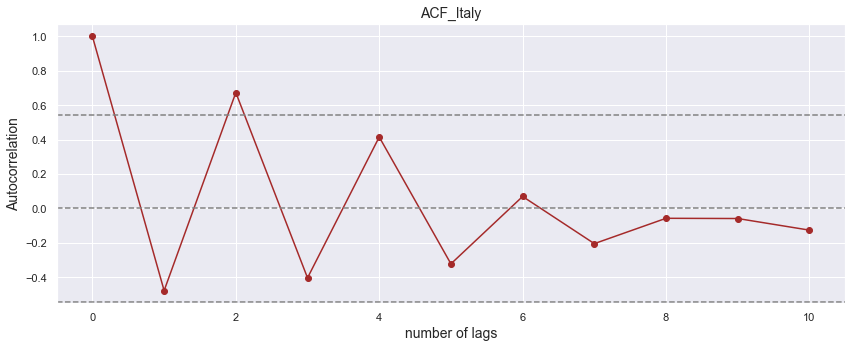

In [42]:
ita_6m_q = ita_6m[['T_ACT_HAND_OUT_QTY']].dropna()
#tutti = tutto_week[['T_ACT_HAND_OUT_QTY']].dropna()
ita_6m_acf = acf(ita_6m_q, nlags=10)
plt.figure(figsize=(12, 5))
plt.plot(ita_6m_acf, marker="o", color = 'brown')
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(depo)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(depo)),linestyle='--',color='gray')
plt.title('ACF_Italy', fontsize = 14)
plt.xlabel('number of lags', fontsize = 14)
plt.ylabel('Autocorrelation', fontsize = 14)
plt.tight_layout()

#### 8.3.2_ PACF

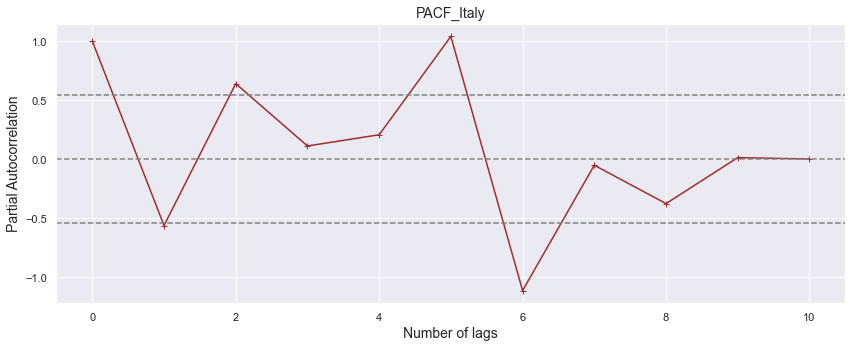

In [43]:
ita_6m_pacf = pacf(ita_6m_q, nlags = 10 , method='ols')
#Plot PACF:
plt.figure(figsize=(12, 5))
plt.plot(ita_6m_pacf, marker='+', color = 'brown')
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(depo)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(depo)),linestyle='--',color='gray')
plt.title('PACF_Italy', fontsize = 14)    
plt.xlabel('Number of lags', fontsize = 14)
plt.ylabel('Partial Autocorrelation', fontsize = 14)
plt.tight_layout()

#### 8.3.3_ Prediction

In [44]:
Z = ita_3m.values
size = int(len(Z) * 0.8)
train_6m, test_6m = Z[0:size], Z[size:len(Z)]
history = [z for z in train_6m]

In [45]:
my_order = (2,0,0)
my_seasonal_order = (2,0,0,6)
model_6m = sm.tsa.statespace.SARIMAX(train_6m, order=my_order, seasonal_order=my_seasonal_order)
model_6m_fit = model_6m.fit(disp = False)

/Users/mehrnazakbari/.pyenv/versions/3.7.3/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:994: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'


In [46]:
yhat_6m = model_6m_fit.forecast(steps = 5, typ = 'levels')
yhat_6m

array([16017.1664116 , 10003.44299449,  9282.72825179, 30851.98642208,
        9454.50231623])

In [47]:
arima6m_fit = ARIMA(train_6m, order=my_order).fit(disp = False)
arima_yhat = arima6m_fit.forecast(steps = 5)[0]
arima_yhat

array([ 5538.57078585, -6318.9692611 , 25961.99010436, 23701.63887528,
        8757.29833365])

Text(0, 0.5, 'Quantity')

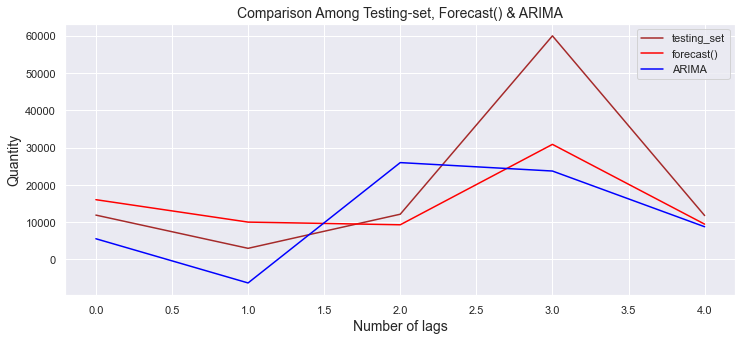

In [48]:
plt.figure(figsize=(12, 5))
pyplot.plot(test_6m, color = 'brown', label = 'testing_set')
#pyplot.plot(yhat_diff, color = 'gold')
pyplot.plot(yhat_6m, color = 'red', label = 'forecast()')
pyplot.plot(arima_yhat, color = 'blue', label = 'ARIMA')
plt.legend()
plt.title('Comparison Among Testing-set, Forecast() & ARIMA', fontsize=14)    
plt.xlabel('Number of lags', fontsize = 14)
plt.ylabel('Quantity', fontsize = 14)

#### 8.3.4_ Accuracy

In [49]:
mse_arima_6m = mean_squared_error(test_6m, arima_yhat)
mse_yhat_6m = mean_squared_error(test_6m, yhat_6m)

if(mse_arima_6m < mse_yhat_6m):
    print("The BLUE line is more accurate.")
elif(mse_arima_6m > mse_yhat_6m):
    print("The RED line is more accurate.")

The RED line is more accurate.


### 8.4_ Differencing the Time-Series (6m)

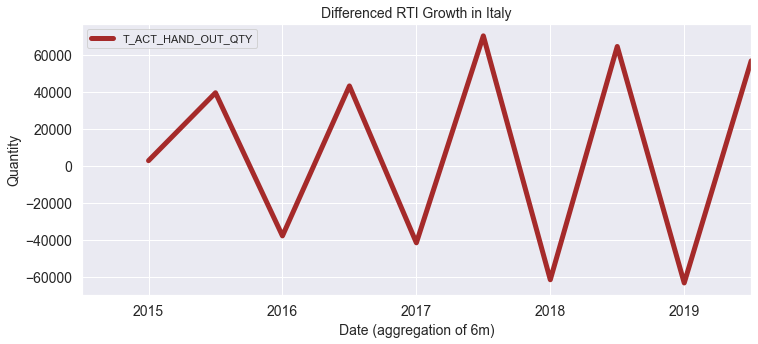

In [50]:
ita_6m_diff = ita_6m.diff()
ita_6m_diff.plot(figsize=(12, 5), linewidth=5, fontsize=14, color = 'brown')
plt.title('Differenced RTI Growth in Italy', fontsize=14)
plt.xlabel('Date (aggregation of 6m)', fontsize=14)
plt.ylabel('Quantity', fontsize = 14)
plt.show()

#### 8.4.1_ Prediction

In [51]:
my_order_diff = (1,1,0)
my_seasonal_order = (1,1,0,6)
model_diff6m = sm.tsa.statespace.SARIMAX(train_6m, order=my_order, seasonal_order=my_seasonal_order)
model_diff6m_fit = model_diff6m.fit(disp = False)

/Users/mehrnazakbari/.pyenv/versions/3.7.3/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:963: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/mehrnazakbari/.pyenv/versions/3.7.3/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:994: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'


In [52]:
yhat_6m_diff = model_6m_fit.forecast(steps = 5, typ = 'levels')
yhat_6m_diff

array([16017.1664116 , 10003.44299449,  9282.72825179, 30851.98642208,
        9454.50231623])

Text(0, 0.5, 'Quantity')

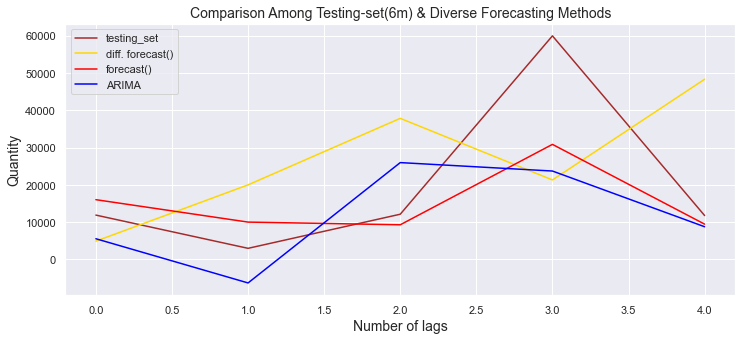

In [53]:
plt.figure(figsize=(12, 5))
pyplot.plot(test_6m, color = 'brown', label = 'testing_set')
pyplot.plot(yhat_diff, color = 'gold', label = 'diff. forecast()')
pyplot.plot(yhat_6m, color = 'red', label = 'forecast()')
pyplot.plot(arima_yhat, color = 'blue', label = 'ARIMA')
plt.legend()
plt.title('Comparison Among Testing-set(6m) & Diverse Forecasting Methods', fontsize=14)    
plt.xlabel('Number of lags', fontsize = 14)
plt.ylabel('Quantity', fontsize = 14)

#### 8.4.2_ Accuracy

In [54]:
mse_yhat_diff_6m = mean_squared_error(test_6m, yhat_diff)

if (min(mse_arima_6m, mse_yhat_6m, mse_yhat_diff_6m) == mse_arima_6m):
    print("the BLUE line indicating ARIMA method is more accurate.")
    
if (min(mse_arima_6m, mse_yhat_6m, mse_yhat_diff_6m) == mse_yhat_6m):
    print("the RED line indicating forecast() method is more accurate.")

if (min(mse_arima_6m, mse_yhat_6m, mse_yhat_diff_6m) == mse_yhat_diff_6m):
    print("the YELLOW line indicating forecast() method on differenced data is more accurate.")

the RED line indicating forecast() method is more accurate.
